**Import do dataset de moedas**

In [ ]:
# Importa a base de dados do Google Drive
import os

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

if(not os.path.exists('/content/dataset')):
  !unzip /content/gdrive/MyDrive/Data/images.zip -d /content/ &> /dev/null

Mounted at /content/gdrive


**Criação do classificador (Yolo v2)**

In [ ]:
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import activations

def make_detector_network(img_cols, img_rows):
  """
  Construção da rede neural convolucional utilizada na classificação

  :param img_cols: número de colunas da imagem de entrada.
  :param img_rows: número de linhas da imagem de entrada.
  :return: modelo Keras da rede neural
  """
  # Input layer
  input_image = Input(shape=(img_cols, img_rows, 3))

  # Layer 1
  layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
  layer = BatchNormalization(name='norm_1')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_1')(layer)

  # Layer 2
  layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_2')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_2')(layer)

  # Layer 3
  layer = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_3')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_3')(layer)
  layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pool_3')(layer)

  # Layer 4
  layer = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_4')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_4')(layer)
  layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pool_4')(layer)

  # Layer 5
  layer = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_5')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_5')(layer)
  layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pool_5')(layer)

  # Layer 6
  layer = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_6')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_6')(layer)
  layer = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same', name='max_pool_6')(layer)

  skip_connection = layer

  # Layer 7A
  layer = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_7')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_7')(layer)

  # Layer 8
  layer = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(layer)
  layer = BatchNormalization(name='norm_8')(layer)
  layer = LeakyReLU(alpha=0.1, name='leaky_relu_8')(layer)

  # Layer 7B
  skip_connection = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='same', name='conv_skip', use_bias=False)(skip_connection)
  skip_connection = BatchNormalization(name='norm_skip')(skip_connection)
  skip_connection = LeakyReLU(alpha=0.1, name='leaky_relu_skip')(skip_connection)

  # Concatenating layers 7B and 8
  layer = concatenate([skip_connection, layer], name='concat')

  # Layer 9
  layer = Conv2D(filters=5, kernel_size=(1, 1), strides=(1, 1), padding='same', name='conv_9', use_bias=True)(layer)
  layer = Flatten(name='Flatten')(layer)
  
  # Layer 10
  layer = Dense(units=5, activation=activations.softmax, name='Dense10')(layer) 

  model = Model(inputs=input_image, outputs=layer, name='CA751_YOLO')

  return model

model = make_detector_network(120, 160)
model.summary()  # prints the network summary

Model: "CA751_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 120, 160, 8)  216         ['input_1[0][0]']                
                                                                                                  
 norm_1 (BatchNormalization)    (None, 120, 160, 8)  32          ['conv_1[0][0]']                 
                                                                                                  
 leaky_relu_1 (LeakyReLU)       (None, 120, 160, 8)  0           ['norm_1[0][0]']        

**Função que realiza o carregamento e pré-processamento das imagens**


In [ ]:
import cv2
import os
import numpy as np

# Carrega as imagens do dataset
def load_images_from_folder(folder):
  images = [] # lista que salva as imagens
  label = [] # lista que salva os labels
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename)) # lê as imagens usando opencv (640x480)
    if img is not None:
      img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA) # redimensiona as imagens para (160, 120)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converte o sistema de cores para RGB
      img = np.array(img) # converte a imagem em um numpy array
      img = img / 255.0 # mapeia os canais de cores para valores entre 0 e 1
      img = np.reshape(img, (120, 160, 3))
      images.append(img)
      label.append(filename.split('_')[0])
  return np.array(images), np.array(label)

**Criação dos conjuntos de treinamento, validação e teste**

In [ ]:
import os
from time import time
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder

EPOCHS = 100
BATCH_SIZE = 64

images, label = load_images_from_folder("/content/dataset")

# Train and test (90/10)
train_features, test_features, train_labels, test_labels = \
    train_test_split(images, label, test_size=0.1)


# ------------------------- Utilizando os novos dados para treinar a rede --------------------------------
if(not os.path.exists('/content/new_dataset')):
  !unzip /content/gdrive/MyDrive/Data/new_images.zip -d /content/ &> /dev/null

new_images, new_label = load_images_from_folder("/content/new_dataset") # prepocessa as imagens
new_train_features, new_test_features, new_train_labels, new_test_labels = \
    train_test_split(new_images, new_label, test_size=0.5) # divide os conjuntos de treino e teste (50/50)
train_features = np.concatenate((train_features, new_train_features)) # inclui o novo dataset no conjunto de treinamento 
train_labels = np.concatenate((train_labels, new_train_labels)) # inclui o novo dataset no conjunto de treinamento 
# ----------------------------------------------------------------------------------------------------------


# Train and validation (80/20)
train_features, validation_features, train_labels, validation_labels = \
    train_test_split(train_features, train_labels, test_size=0.2)

#print('# of training images:', train_features.shape[0])
#print('# of cross-validation images:', validation_features.shape[0])

# Pre-processing data and build generator
onehot_encoder = OneHotEncoder(sparse=False)

train_labels = np.reshape(train_labels, (train_labels.shape[0], 1)) # reshape train_labels
validation_labels = np.reshape(validation_labels, (validation_labels.shape[0], 1)) # reshape validation_labels

X_train, y_train = train_features, onehot_encoder.fit_transform(train_labels)
X_validation, y_validation = validation_features, onehot_encoder.fit_transform(validation_labels)

#train_generator = ImageDataGenerator(rotation_range=180, width_shift_range=0.5, 
#                                     height_shift_range=0.5, horizontal_flip=True, 
#                                     vertical_flip=True, brightness_range=[0.2,1.8]
#                                     ).flow(X_train, y_train, batch_size=BATCH_SIZE)
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)                                     
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_validation.shape[0] // BATCH_SIZE

# Build and compile model
model = make_detector_network(120, 160)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

# Checking if weights from previous learning session exists
if os.path.exists('/content/gdrive/MyDrive/Data/yolo_coins.h5'):
    print('Loading weights from previous learning session.')
    model.load_weights("/content/gdrive/MyDrive/Data/yolo_coins.h5")
else:
    print('No weights found from previous learning session.')

Loading weights from previous learning session.


**Treinamento da Rede**

In [ ]:
# Training the Neural Network
model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, 
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
model.save_weights("/content/gdrive/MyDrive/Data/yolo_coins.h5")

Epoch 1/100
35/35 [==============================] - 4s 88ms/step - loss: 0.0529 - accuracy: 0.9821 - val_loss: 3.7541 - val_accuracy: 0.4668
Epoch 2/100
35/35 [==============================] - 3s 80ms/step - loss: 0.0745 - accuracy: 0.9754 - val_loss: 2.4593 - val_accuracy: 0.6328
Epoch 3/100
35/35 [==============================] - 3s 80ms/step - loss: 0.0803 - accuracy: 0.9759 - val_loss: 2.6344 - val_accuracy: 0.6953
Epoch 4/100
35/35 [==============================] - 3s 80ms/step - loss: 0.0509 - accuracy: 0.9821 - val_loss: 4.7328 - val_accuracy: 0.4590
Epoch 5/100
35/35 [==============================] - 3s 80ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 3.2777 - val_accuracy: 0.5449
Epoch 6/100
35/35 [==============================] - 3s 80ms/step - loss: 0.0296 - accuracy: 0.9902 - val_loss: 5.6265 - val_accuracy: 0.4590
Epoch 7/100
35/35 [==============================] - 3s 81ms/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 4.9150 - val_accuracy: 0.4492
Epoch 

**Avaliação da rede**

In [ ]:
# Evaluating the Neural Network
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

predicted_labels = model.predict(test_features)

onehot_encoder = OneHotEncoder(sparse=False)
test_labels_onehoted = onehot_encoder.fit_transform(np.reshape(test_labels, (test_labels.shape[0], 1)))
score = model.evaluate(test_features, test_labels_onehoted)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Making the Confusion Matrix
y_pred_final = []
y_test_final = []

for i in range(0, predicted_labels.shape[0]):
    y_pred_final.append((list(predicted_labels[i]).index(max(predicted_labels[i])) + 1))
    y_test_final.append((list(test_labels_onehoted[i]).index(max(test_labels_onehoted[i])) + 1))
  
cm = confusion_matrix(y_test_final, y_pred_final)

print('Confusion matrix:')
print(cm)

9/9 [==============================] - 0s 15ms/step - loss: 1.1036 - accuracy: 0.8333
Test loss: 1.103573203086853
Test accuracy: 0.8333333134651184
Confusion matrix:
[[43  0  0 15  1]
 [ 0 38  6  0  0]
 [ 1  5 49  1  0]
 [ 4  0  1 45  2]
 [ 5  0  1  4 55]]


**Avaliação da rede com o novo dataset gerado**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

# # Importa as imagens
# if(not os.path.exists('/content/new_dataset')):
#   !unzip /content/gdrive/MyDrive/Data/new_images.zip -d /content/ &> /dev/null

# new_test_features, new_test_labels = load_images_from_folder("/content/new_dataset") #prepocessa as imagens

new_predicted_labels = model.predict(new_test_features)

onehot_encoder = OneHotEncoder(sparse=False)
new_test_labels_onehoted = onehot_encoder.fit_transform(np.reshape(new_test_labels, (new_test_labels.shape[0], 1)))
score = model.evaluate(new_test_features, new_test_labels_onehoted)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Making the Confusion Matrix
y_pred_final = []
y_test_final = []

for i in range(0, new_predicted_labels.shape[0]):
    y_pred_final.append((list(new_predicted_labels[i]).index(max(new_predicted_labels[i])) + 1))
    y_test_final.append((list(new_test_labels_onehoted[i]).index(max(new_test_labels_onehoted[i])) + 1))
  
new_cm = confusion_matrix(y_test_final, y_pred_final)

print('Confusion matrix:')
print(new_cm)

11/11 [==============================] - 0s 13ms/step - loss: 4.0244 - accuracy: 0.5015
Test loss: 4.024430274963379
Test accuracy: 0.5015479922294617
Confusion matrix:
[[41  2 19 49  0]
 [ 7  2  4  5  1]
 [17  0 14 16  0]
 [22  1  5 77  1]
 [ 4  3  1  4 28]]


**Imprime na tela alguns exemplos de classificações corretas e incorretas do novo conjunto de teste**

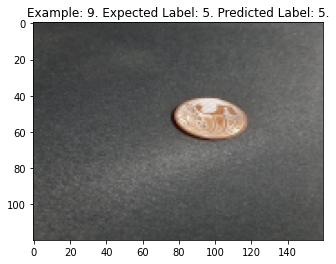

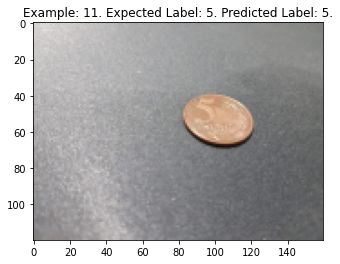

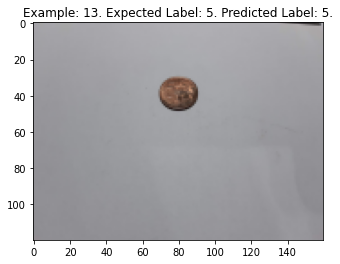

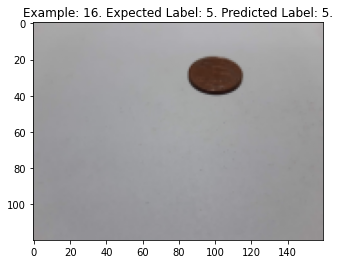

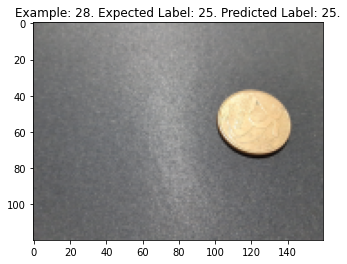

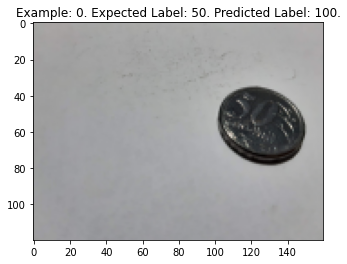

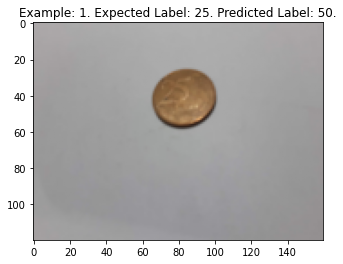

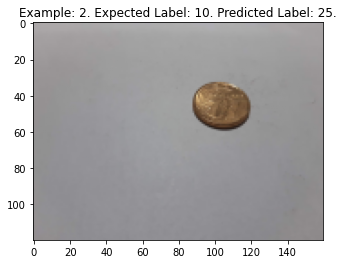

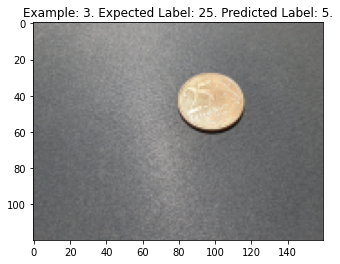

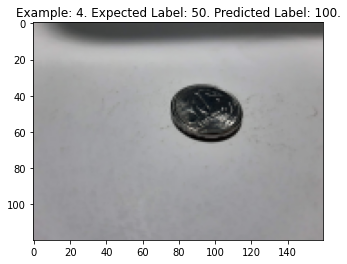

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

# Função utilizada para exibir as imagens no tela
def display_image(image, title):
    image = image.squeeze()
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=plt.cm.gray_r)

# Mostra alguns exemplos de classificações corretas e incorretas
NUM_IMAGES_CORRECT_CLASSIFICATION = 5
NUM_IMAGES_MISCLASSIFICATION = 5

# make results folder to save images
if not os.path.exists('results'):
  os.makedirs('results')

# Convert preditic labels to the real value
real_predicted_label = []
for i in range(new_predicted_labels.shape[0]):
  value = np.argmax(new_predicted_labels[i, :])
  if value == 0:
    real_predicted_label.append(5)
  if value == 1:
    real_predicted_label.append(10)
  if value == 2:
    real_predicted_label.append(25)
  if value == 3:
    real_predicted_label.append(50)
  if value == 4:
    real_predicted_label.append(100)

count = 0
for i in range(new_test_features.shape[0]):
    if count == NUM_IMAGES_CORRECT_CLASSIFICATION:
        break
    if real_predicted_label[i] == new_test_labels[i].astype(int):
        display_image(new_test_features[i],
                      'Example: %d. Expected Label: %d. Predicted Label: %d.' %
                      (i, new_test_labels[i].astype(int), real_predicted_label[i]))
        plt.savefig('results/correct_classified_image_%d.png' % i, format='png')
        count += 1

count = 0
for i in range(new_test_features.shape[0]):
    if count == NUM_IMAGES_MISCLASSIFICATION:
        break
    if real_predicted_label[i] != new_test_labels[i].astype(int):
        display_image(new_test_features[i],
                      'Example: %d. Expected Label: %d. Predicted Label: %d.' %
                      (i, new_test_labels[i].astype(int), real_predicted_label[i]))
        plt.savefig('results/misclassified_image_%d.png' % i, format='png')
        count += 1

plt.show()

from google.colab import files
import os
os.system('zip -r projeto_final.zip results')
files.download("projeto_final.zip")